# Проект: Обучение с учителем: качество модели

**описание проекта**

    Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
    
    
**цель проекта**

 
    Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
    В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
    Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
    
    
**план работы**

    Загрузка данных
    Предобработка данных
    Исследовательский анализ данных
    Объединение таблиц
    Корреляционный анализ
    Использование пайплайнов
    Анализ важности признаков
    Сегментация покупателей
    Общий вывод


In [1]:
!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
import phik 
import seaborn as sns
import shap

from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
                        
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
                                  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Шаг 1. Загрузка данных

In [3]:
data_market_file = pd.read_csv('/datasets/market_file.csv')
display(data_market_file.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
data_market_money = pd.read_csv('/datasets/market_money.csv')
display(data_market_money.head())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
data_time = pd.read_csv('/datasets/market_time.csv')
display(data_time.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
data_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=(','))
display(data_money.head())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Шаг 2. Предобработка данных

In [7]:
data_market_file.columns = map(str.lower, data_market_file.columns)
data_market_file.columns = data_market_file.columns.str.replace(' ', '_')
data_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [8]:
display(data_market_file["покупательская_активность"].unique())
display(data_market_file["тип_сервиса"].unique())
display(data_market_file["разрешить_сообщать"].unique())
display(data_market_file["популярная_категория"].unique())

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [9]:
data_market_file["тип_сервиса"] = data_market_file["тип_сервиса"].replace('стандартт','стандарт')
display(data_market_file["тип_сервиса"].unique())

array(['премиум', 'стандарт'], dtype=object)

In [10]:
display(data_market_file.duplicated().sum())

0

In [11]:
data_market_money.columns = map(str.lower, data_market_money.columns)

In [12]:
data_market_money.columns = map(str.lower, data_market_money.columns)
display(data_market_money["период"].unique())
display(data_market_money.duplicated().sum())
data_market_money.info()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [13]:
data_time.columns = map(str.lower, data_time.columns)
display(data_time.duplicated().sum())
display(data_time["период"].unique())
data_time.info()

0

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
data_time["период"] = data_time["период"].replace('предыдцщий_месяц','предыдущий_месяц')
display(data_time["период"].unique())

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [15]:
data_money.columns = map(str.lower, data_money.columns)
display(data_money.duplicated().sum())
data_money.info()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


пропусков не обнаружено 

дубликатов нет 

неявные дубликаты обработаны 

название столбцов приведены к нижнему и змеиному регистру 



## Шаг 3. Исследовательский анализ данных

In [16]:
num = ['маркет_актив_6_мес',
       'маркет_актив_тек_мес',
       'длительность',
       'акционные_покупки',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал',
       'ошибка_сервиса',
       'страниц_за_визит'
      ] 

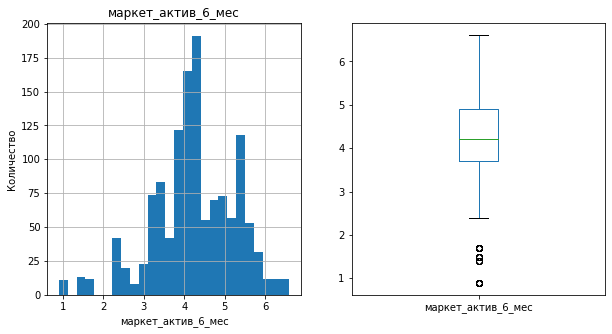

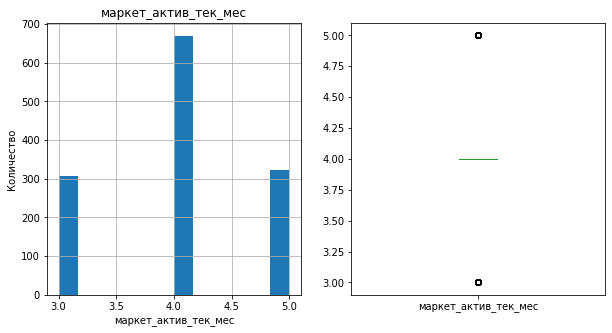

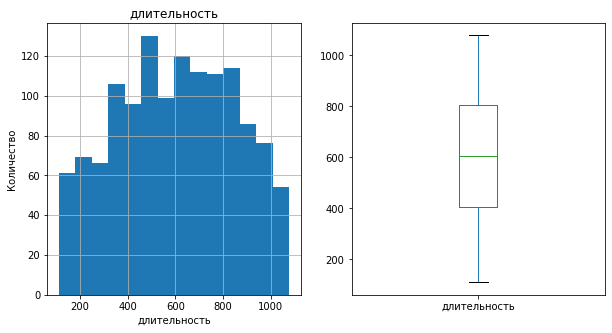

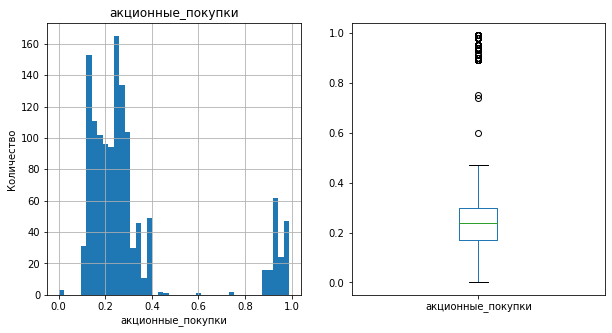

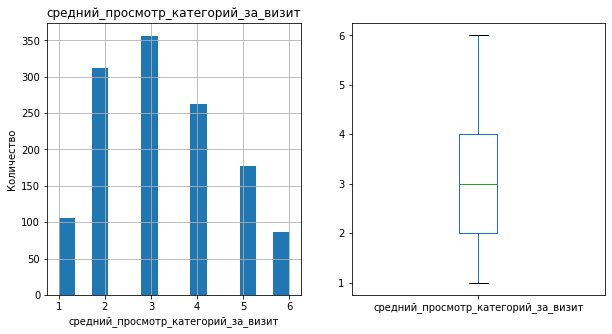

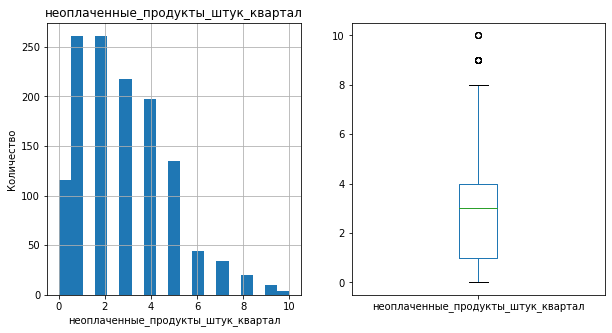

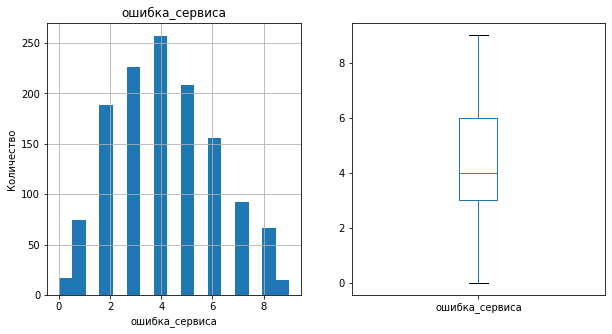

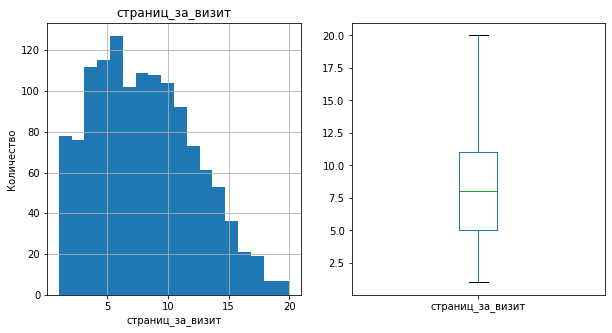

In [17]:
for i in num:
    plt.figure(figsize=[10, 5])
    plt.subplot(1, 2, 1)
    data_market_file[i].hist(bins='auto', grid=True)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    data_market_file[i].plot(kind='box')
    plt.show()
    

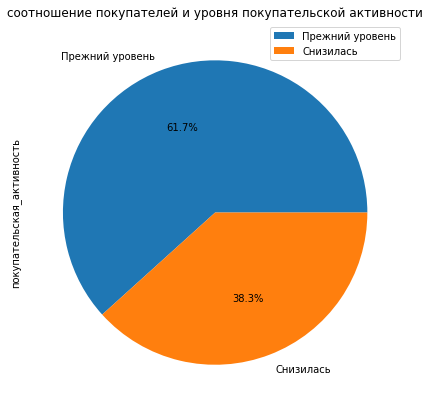

In [18]:
data_market_file.pivot_table(index='покупательская_активность', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7),  label='покупательская_активность', autopct='%1.1f%%', title='соотношение покупателей и уровня покупательской активности')

plt.show()

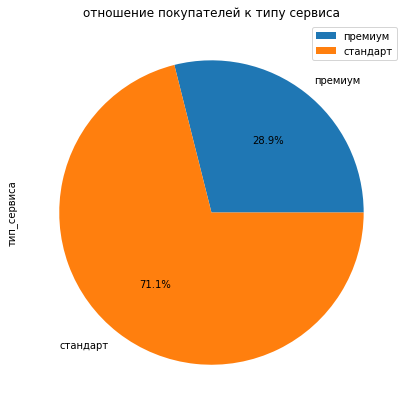

In [19]:
data_market_file.pivot_table(index='тип_сервиса', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7),  label='тип_сервиса', autopct='%1.1f%%', title='отношение покупателей к типу сервиса')

plt.show()

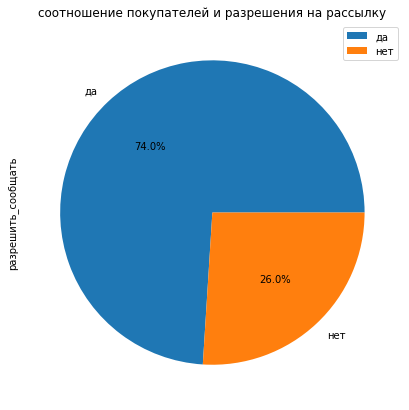

In [20]:
data_market_file.pivot_table(index='разрешить_сообщать', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7),  label='разрешить_сообщать', autopct='%1.1f%%', title='соотношение покупателей и разрешения на рассылку')

plt.show()

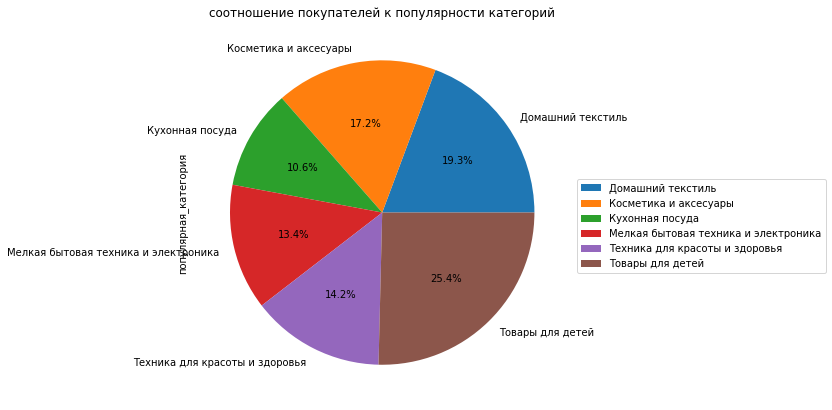

In [21]:
data_market_file.pivot_table(index='популярная_категория', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7),  label='популярная_категория', autopct='%1.1f%%', title='соотношение покупателей к популярности категорий')
plt.legend(bbox_to_anchor=(1, 0.6))
plt.show()

In [22]:
data_market_money = data_market_money[data_market_money.id.isin(data_market_money.query('выручка==0')['id'].unique())==False]
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   период   3891 non-null   object 
 2   выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


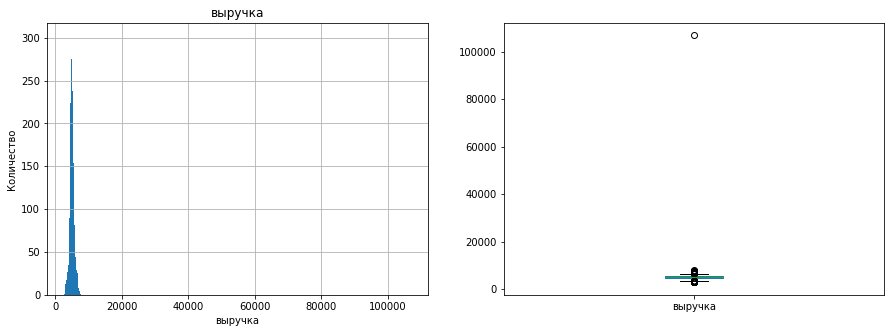

In [23]:
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 2, 1)
    data_market_money['выручка'].hist(bins='auto', grid=True)
    plt.title('выручка')
    plt.xlabel('выручка')
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    data_market_money['выручка'].plot(kind='box')
    plt.show()

In [24]:
data_market_money = data_market_money[data_market_money['выручка'] < 20000]

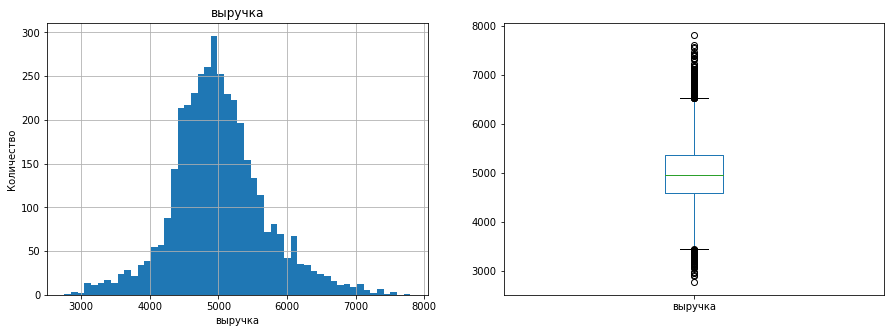

In [25]:
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 2, 1)
    data_market_money['выручка'].hist(bins='auto', grid=True)
    plt.title('выручка')
    plt.xlabel('выручка')
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    data_market_money['выручка'].plot(kind='box')
    plt.show()

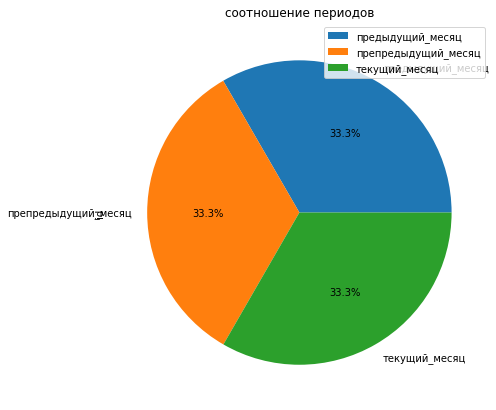

In [26]:
data_market_money.pivot_table(index='период', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7), autopct='%1.1f%%', title='соотношение периодов')

plt.show()

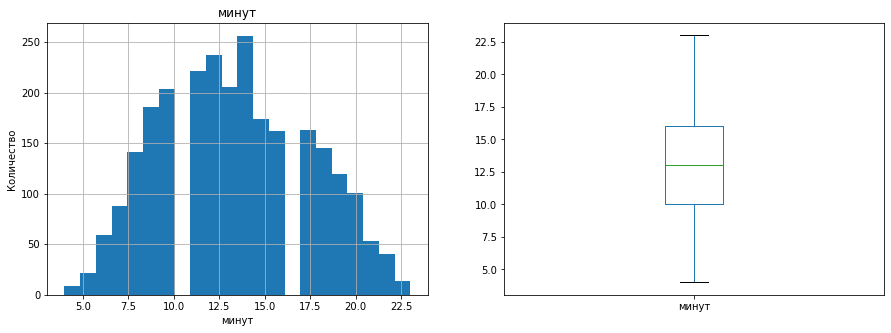

In [27]:
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 2, 1)
    data_time['минут'].hist(bins='auto', grid=True)
    plt.title('минут')
    plt.xlabel('минут')
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    data_time['минут'].plot(kind='box')
    plt.show()

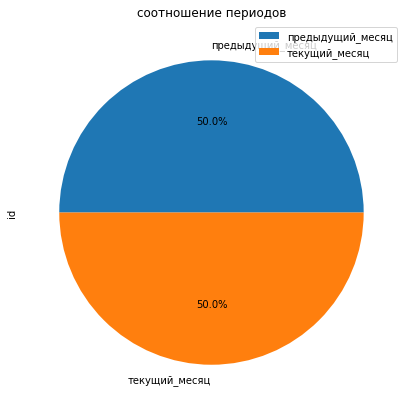

In [28]:
data_time.pivot_table(index='период', values='id', aggfunc='count').plot.pie(y='id', figsize=(7,7), autopct='%1.1f%%', title='соотношение периодов')

plt.show()

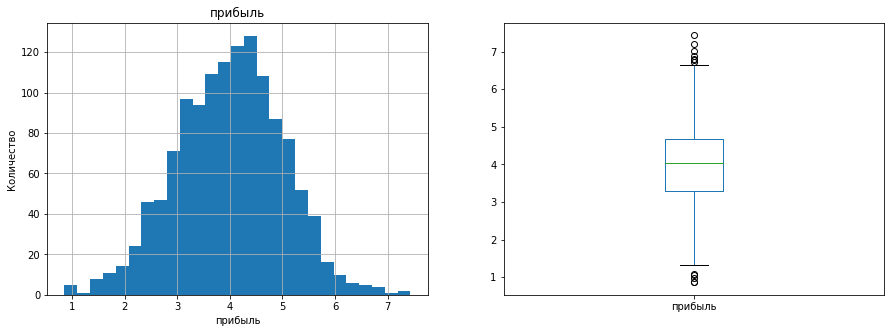

In [29]:
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 2, 1)
    data_money['прибыль'].hist(bins='auto', grid=True)
    plt.title('прибыль')
    plt.xlabel('прибыль')
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    data_money['прибыль'].plot(kind='box')
    plt.show()

    числовые значения 

    большинство графиков имеют близкое к нормальному распределению 

    аномалия в признаке выручка была удалена 

    самое не нормальное распределение у признака акционные покупки имеет 2 пика большой пик около значения 0.2 2 пик поменьше около значения 0.9

    категориальные значения
    покупательская активность у 38 процентов клиентов снизилась 
    тип сервиса только 29 процентов покупателей пользуються подпиской премиум
    разрешить сообщать 74 процента согласны на рассылки и звонки 
    популярная категория на 1 месте товары для детей 25,4 процента на 2 месте домашний текстиль 19,3 на 3 месте косметика и аксесуары 17,2 
    
    
    
    
    



## Шаг 4. Объединение таблиц

In [30]:
df_1 = data_time[data_time['период']=='предыдущий_месяц'].copy()
df_1.rename(columns={'минут':'минут_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )

df_2 = data_time[data_time['период']=='текущий_месяц'].copy()
df_2.rename(columns={'минут':'минут_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )

df_time = pd.merge(df_1, df_2, on='id')

display(df_time.info())
display(df_time.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   id                        1300 non-null   int64
 1   минут_предыдущего_месяца  1300 non-null   int64
 2   минут_текущего_месяца     1300 non-null   int64
dtypes: int64(3)
memory usage: 40.6 KB


None

,id,минут_предыдущего_месяца,минут_текущего_месяца
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [31]:
df_1 = data_market_money[data_market_money['период']=='текущий_месяц'].copy()
df_1.rename(columns={'выручка':'выручка_предыдущего_месяца'},inplace=True)
df_1.drop('период', axis= 1 , inplace= True )
df_2 = data_market_money[data_market_money['период']=='предыдущий_месяц'].copy()
df_2.rename(columns={'выручка':'выручка_текущего_месяца'},inplace=True)
df_2.drop('период', axis= 1 , inplace= True )
df_3 = data_market_money[data_market_money['период']=='препредыдущий_месяц'].copy()
df_3.rename(columns={'выручка':'выручка_препредыдущего_месяца'},inplace=True)
df_3.drop('период', axis= 1 , inplace= True )
df_market_money = pd.merge(df_1, df_2, on='id')
df_market_money = pd.merge(df_3, df_market_money, on='id')
display(df_market_money.info())
display(df_market_money.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1296 non-null   int64  
 1   выручка_препредыдущего_месяца  1296 non-null   float64
 2   выручка_предыдущего_месяца     1296 non-null   float64
 3   выручка_текущего_месяца        1296 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.6 KB


None

,id,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца
0,215349,4472.0,4971.6,5216.0
1,215350,4826.0,5058.4,5457.5
2,215351,4793.0,6610.4,6158.0
3,215352,4594.0,5872.5,5807.5
4,215353,5124.0,5388.5,4738.5


In [32]:
data = pd.merge(df_market_money, data_market_file, on='id')

In [33]:
data = pd.merge(df_time, data, on='id')

In [34]:
display(data.head())
display(data.info())

,id,минут_предыдущего_месяца,минут_текущего_месяца,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215349,12,10,4472.0,4971.6,5216.0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,8,13,4826.0,5058.4,5457.5,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,11,13,4793.0,6610.4,6158.0,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,8,11,4594.0,5872.5,5807.5,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,10,10,5124.0,5388.5,4738.5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   минут_предыдущего_месяца             1296 non-null   int64  
 2   минут_текущего_месяца                1296 non-null   int64  
 3   выручка_препредыдущего_месяца        1296 non-null   float64
 4   выручка_предыдущего_месяца           1296 non-null   float64
 5   выручка_текущего_месяца              1296 non-null   float64
 6   покупательская_активность            1296 non-null   object 
 7   тип_сервиса                          1296 non-null   object 
 8   разрешить_сообщать                   1296 non-null   object 
 9   маркет_актив_6_мес                   1296 non-null   float64
 10  маркет_актив_тек_мес                 1296 non-null   int64  
 11  длительность                  

None

## Шаг 5. Корреляционный анализ

In [35]:
data = data.set_index('id')

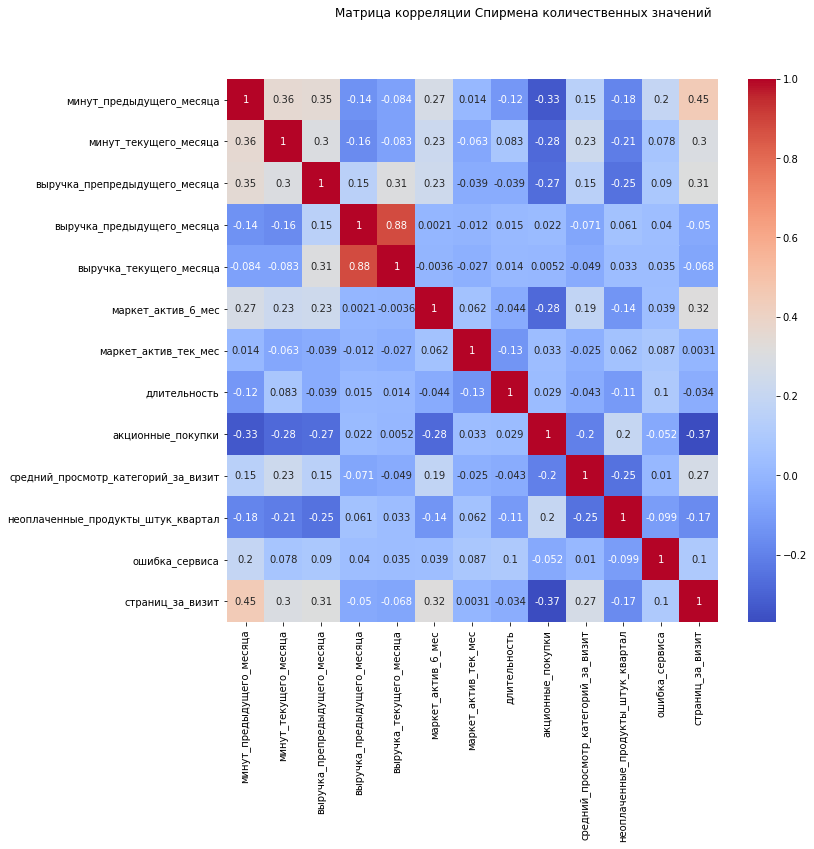

In [36]:
fig, ax = plt.subplots(figsize=(11, 10))
plt.suptitle('Матрица корреляции Спирмена количественных значений')
sns.heatmap(data.corr(method="spearman"), annot=True, cmap='coolwarm');

мультиколинеарность не обнаружена

высокая кореляция между выручками текущего и предыдущего месяца 

средняя кореляция между минут предыдущего месяца и страниц за визит



## Шаг 6. Использование пайплайнов

In [37]:
X = data.drop(['покупательская_активность'], axis=1)
y = data['покупательская_активность']
y = y.apply(lambda x: 1 if x=='Снизилась' else 0)
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify = y)

In [38]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = ['выручка_препредыдущего_месяца',       
               'выручка_предыдущего_месяца',          
               'выручка_текущего_месяца',             
               'минут_предыдущего_месяца',            
               'минут_текущего_месяца',               
               'маркет_актив_6_мес',                  
               'маркет_актив_тек_мес',                
               'длительность',                        
               'акционные_покупки',                   
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',  
               'ошибка_сервиса',                      
               'страниц_за_визит']

In [39]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт','премиум'], 
                    ['нет','да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },


    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }    
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


y_test_pred = randomized_search.predict_proba(X_test) 
probabilities_one = y_test_pred[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

лучшей моделью оказалась SVC(C=1, probability=True) 

Метрика лучшей модели на тренировочной выборке: 0.908

Метрика ROC-AUC на тестовой выборке: 0.912

выбрал метрику ROC-AUC потому что это самая общая оценка итогов работы модели нам не нужно точно опряделять какой-то класс нужно чтобы модель точно определяла все классы также эту Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими у нас значений 1 класса 61,7% 2 класса 38,3%

## Шаг 7. Анализ важности признаков

In [40]:
best_model = randomized_search.best_estimator_
pipe_final = Pipeline([
    ('preprocessor', (best_model.named_steps['preprocessor'])),
    ('models',best_model.named_steps['models']) 
]).fit(X_train, y_train)






In [41]:
X_train_trans = pd.DataFrame(best_model.named_steps['preprocessor'].transform(X_train), columns=best_model.named_steps['preprocessor'].get_feature_names_out())
X_test_trans = pd.DataFrame(best_model.named_steps['preprocessor'].transform(X_test), columns=best_model.named_steps['preprocessor'].get_feature_names_out())
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_trans)
shap_values = explainer.shap_values(X_test_trans, nsamples=100)


Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/324 [00:00<?, ?it/s]

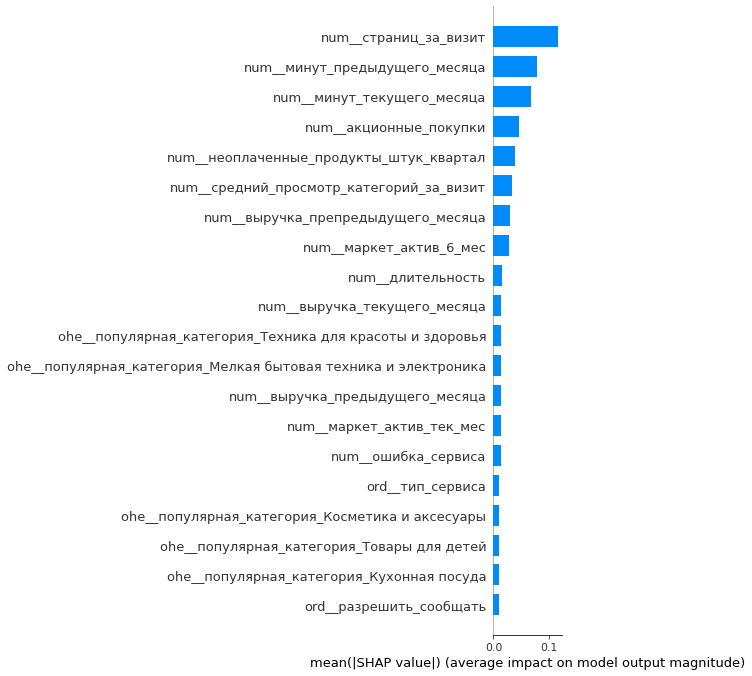

In [42]:
shap.summary_plot(shap_values, X_test_trans, plot_type='bar')

    больше всего на целевой признак влияют такие входные:
    неоплаченые товары
    маркет актив 6 мес
    страниц за визит
    акционные покупки 
    меньше всего: 
    разрешение на рассылку
    тип сервиса

советую уделить внимание на маркетинговые коммуникации компании с клиентом так как это довольно сильно влияет на целевой признак 
а также количество времени проведенное клиентом на сайте магазина 


## Шаг 8. Сегментация покупателей

In [43]:
display(X.head())

,минут_предыдущего_месяца,минут_текущего_месяца,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,,,,,
215349,12,10,4472.0,4971.6,5216.0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,8,13,4826.0,5058.4,5457.5,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,11,13,4793.0,6610.4,6158.0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,8,11,4594.0,5872.5,5807.5,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
215353,10,10,5124.0,5388.5,4738.5,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


In [44]:
def custom_predict(X, threshold):
    probs = best_model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

In [45]:
predictions_precision = custom_predict(X, threshold=0.5)
X['predictions'] = predictions_precision
X['probs'] = pipe_final.predict_proba(X)[:,1]

In [46]:
X = pd.merge(X, data_money, on='id')

In [47]:
display(X.head())

,id,минут_предыдущего_месяца,минут_текущего_месяца,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,predictions,probs,прибыль
0,215349,12,10,4472.0,4971.6,5216.0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,0.979680,4.16
1,215350,8,13,4826.0,5058.4,5457.5,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,1,0.548046,3.13
2,215351,11,13,4793.0,6610.4,6158.0,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,1,0.819377,4.87
3,215352,8,11,4594.0,5872.5,5807.5,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,1,0.949660,4.21
4,215353,10,10,5124.0,5388.5,4738.5,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,1,0.808037,3.95


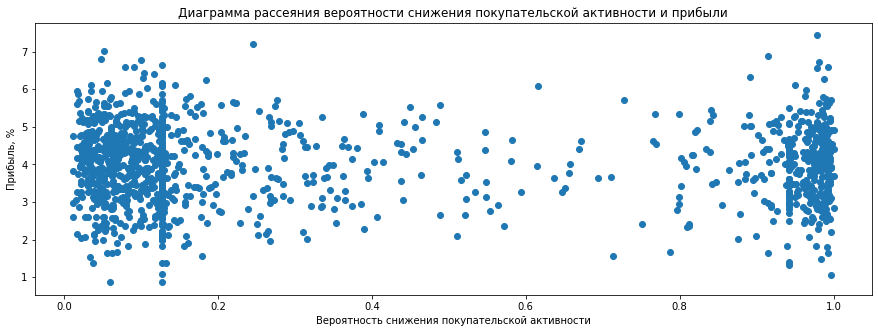

In [48]:
plt.figure(figsize=[15, 5])
plt.scatter(X['probs'], X['прибыль']);
plt.title('Диаграмма рассеяния вероятности снижения покупательской активности и прибыли')
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль, %')
plt.show()

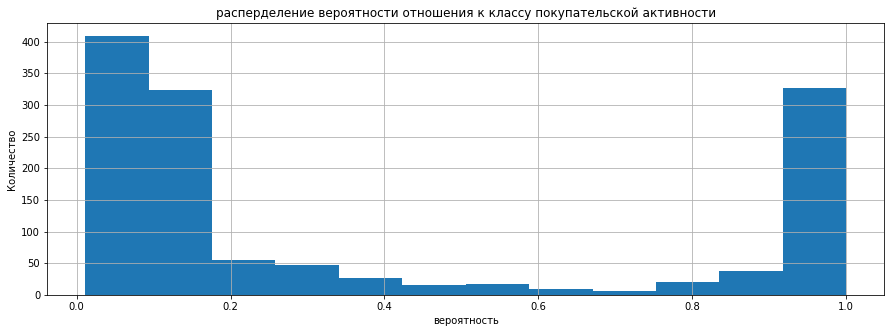

In [49]:
X['probs'].hist(bins='auto', grid=True, figsize=[15, 5])
plt.title('расперделение вероятности отношения к классу покупательской активности')
plt.xlabel('вероятность')
plt.ylabel('Количество')
plt.show()

In [50]:
X['покупательская_активность_пред'] = X['probs'].apply(lambda x: 'Снизилась' if x > 0.5 else 'Прежний уровень')   

In [51]:
X = pd.merge(X, y, on='id')

In [52]:
X['покупательская_активность'] = X['покупательская_активность'].apply(lambda x: 'Снизилась' if x > 0.5 else 'Прежний уровень')   

In [53]:
display(X.head())

,id,минут_предыдущего_месяца,минут_текущего_месяца,выручка_препредыдущего_месяца,выручка_предыдущего_месяца,выручка_текущего_месяца,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,...,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,predictions,probs,прибыль,покупательская_активность_пред,покупательская_активность
0,215349,12,10,4472.0,4971.6,5216.0,премиум,да,4.4,4,...,Товары для детей,4,4,2,5,1,0.979680,4.16,Снизилась,Снизилась
1,215350,8,13,4826.0,5058.4,5457.5,стандарт,нет,4.9,3,...,Домашний текстиль,5,2,1,5,1,0.548046,3.13,Снизилась,Снизилась
2,215351,11,13,4793.0,6610.4,6158.0,стандарт,да,3.2,5,...,Товары для детей,5,0,6,4,1,0.819377,4.87,Снизилась,Снизилась
3,215352,8,11,4594.0,5872.5,5807.5,стандарт,нет,5.1,3,...,Товары для детей,3,2,3,2,1,0.949660,4.21,Снизилась,Снизилась
4,215353,10,10,5124.0,5388.5,4738.5,стандарт,да,3.3,4,...,Домашний текстиль,4,1,1,4,1,0.808037,3.95,Снизилась,Снизилась


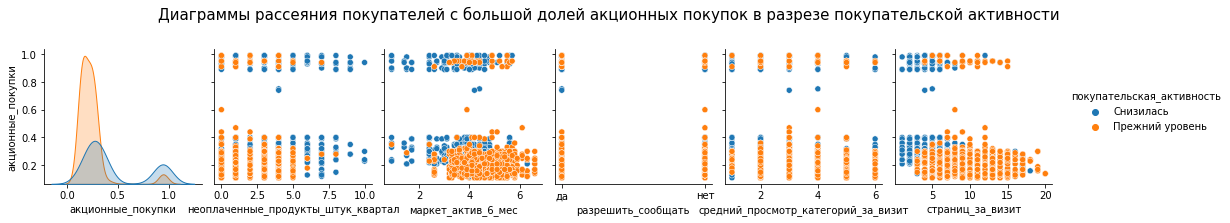

In [54]:
x=['акционные_покупки',
   'неоплаченные_продукты_штук_квартал',
   'маркет_актив_6_мес',
   'разрешить_сообщать',
   'средний_просмотр_категорий_за_визит',
   'страниц_за_визит'
  ]

y=['акционные_покупки'
  ]

g = sns.pairplot(X, hue='покупательская_активность', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе покупательской активности", y=1.2, fontsize=15,)
plt.show()

In [55]:
X['прибыль'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

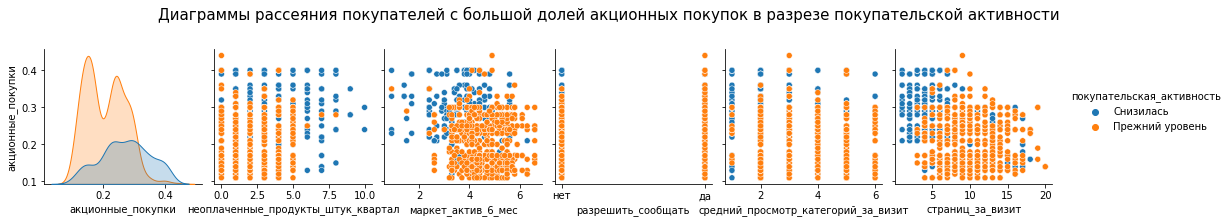

In [56]:
x=['акционные_покупки',
   'неоплаченные_продукты_штук_квартал',
   'маркет_актив_6_мес',
   'разрешить_сообщать',
   'средний_просмотр_категорий_за_визит',
   'страниц_за_визит'
  ]

y=['акционные_покупки'
  ]

g = sns.pairplot(X.query('прибыль < 4.7   & акционные_покупки < 0.5'), hue='покупательская_активность', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большой долей акционных покупок в разрезе покупательской активности", y=1.2, fontsize=15,)
plt.show()

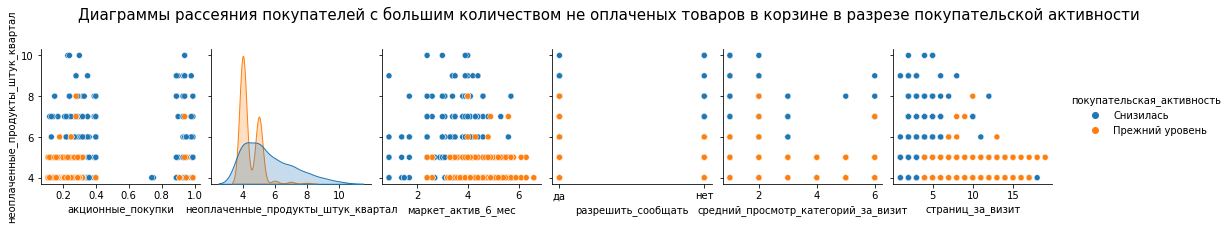

In [57]:
x=['акционные_покупки',
   'неоплаченные_продукты_штук_квартал',
   'маркет_актив_6_мес',
   'разрешить_сообщать',
   'средний_просмотр_категорий_за_визит',
   'страниц_за_визит'
  ]

y=['неоплаченные_продукты_штук_квартал'
  ]

g = sns.pairplot(X.query(' неоплаченные_продукты_штук_квартал > 3'), hue='покупательская_активность', x_vars=x, y_vars=y)
g.fig.suptitle("Диаграммы рассеяния покупателей с большим количеством не оплаченых товаров в корзине в разрезе покупательской активности", y=1.2, fontsize=15,)
plt.show()

после рассмотрения графиков можно заметить сегмент в которм большое снижение активности 

это сигмент покупателей с большим количеством неоплаченого товара в корзине от 5 штук

скорее всего это происходит потому что клиент добовляет интересующий его товар в корзину и ждет когда на него будет скидка и после этого его покупает 

также снижение активности в сегменте покупателей получающие меньше рассылок и звонков 

рекомендация для повышения активности 

    совершать больше  маркетинговых коммуникаций с клиентом 
    предлогать клиентам персональную скидку на товары в их корзине 


## Шаг 9. Общий вывод

**основные действия**     

    загрузили 3 датасета 
    переименовали столбцы 
    удалили явные и не явные дубликаты 
    Проведен анализ данных 
    Замеченные аномалии были удалены. 
    

           *числовые значения*

    большинство графиков имеют близкое к нормальному распределению 

    аномалия в признаке выручка была удалена 

    самое не нормальное распределение у признака акционные покупки имеет 2 пика большой пик около значения 0.2 2 пик поменьше около значения 0.9

    
   
           *строковые значения*

    покупательская активность у 38 процентов клиентов снизилась 
    тип сервиса только 29 процентов покупателей пользуються подпиской премиум
    разрешить сообщать 74 процента согласны на рассылки и звонки 
    популярная категория на 1 месте товары для детей 25,4 процента на 2 месте домашний текстиль 19,3 на 3 месте косметика и аксесуары 17,2 
    
    объединили таблицы
        
   
**Корреляционный анализ**

    мультиколинеарность не обнаружена

    высокая кореляция между выручками текущего и предыдущего месяца 

    средняя кореляция между минут предыдущего месяца и страниц за визит

**Использование пайплайнов**

    лучшей моделью оказалась SVC(C=1, probability=True)

    Метрика лучшей модели на тренировочной выборке: 0.913

    Метрика ROC-AUC на тестовой выборке: 0.847
     

**Анализ важности признаков**

    больше всего на целевой признак влияют такие входные:
    неоплаченые товары
    маркет актив 6 мес
    категория косметика и аксесуары
    каьегория товары для детей
    акционные покупки 
    разрешение на рассылку
    меньше всего:
    страниц за визит
    мелкая бытовая техника 
    техника для красоты и здоровья 


    советую уделить внимание на маркетинговые коммуникации компании с клиентом так как это довольно сильно влияет на целевой признак 
    
    
    
**Сегментация покупателей**   

    после рассмотрения графиков можно заметить сегмент в которм большое снижение активности 

    это сигмент покупателей с большим количеством неоплаченого товара в корзине от 5 штук

    скорее всего это происходит потому что клиент добовляет интересующий его товар в корзину и ждет когда на него будет скидка и после этого его покупает 

    также снижение активности в сегменте покупателей получающие меньше рассылок и звонков 

    рекомендация для повышения активности: 

    совершать больше  маркетинговых коммуникаций с клиентом 
    предлогать клиентам персональную скидку на товары в их корзине 